In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Modelling
from xgboost import XGBRegressor
import lightgbm as lgb

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'data_description.txt', 'train.csv']


## Reading Data

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
submission = pd.read_csv('../input/sample_submission.csv')

Let's take a quick look at the dataset

In [4]:
train.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
print(f'Shape of Train Set: {train.shape}')
print(f'Shape of Test Set : {test.shape}')

Shape of Train Set: (1460, 81)
Shape of Test Set : (1459, 80)


## EDA

#### Plotting Data Types

The function *plot_dtypes* identifies the number of distinct data types in our dataset.

In [6]:
def plot_dtypes(df):
    # Get dataframe with count of each dtype
    dtypes = pd.DataFrame(df.dtypes, columns = ['dtype'])
    dtypes = dtypes.groupby('dtype').size().rename('count').reset_index()
    
    # Plot resulting dataframe
    ax = dtypes.sort_values('count').plot(
        'dtype',
        kind = 'barh', 
        figsize=(8,6), 
        title='Number of Distinct Data Types in Dataset', 
        legend = None, 
        color = '#c19a6b'
        )
    
    # List that will hold plt.patches data
    totals = []

    # Append patch values to list
    for i in ax.patches:
        totals.append(i.get_width())

    # Denominator for percentage
    total = sum(totals)

    # Set individual bar lables
    for i in ax.patches:
        # get_width to move left or right; get_y to move up or down
        # For regular bar, switch get_width and get_y 
        # Change get_width to get_height, get_y to get_x
        ax.text(
            i.get_width() + .3, i.get_y() + .2,
            str(round((i.get_width() / total)*100, 2))+'%', 
            fontsize=12,
            color='blue'
        )
    
    plt.style.use('ggplot')
    plt.show()

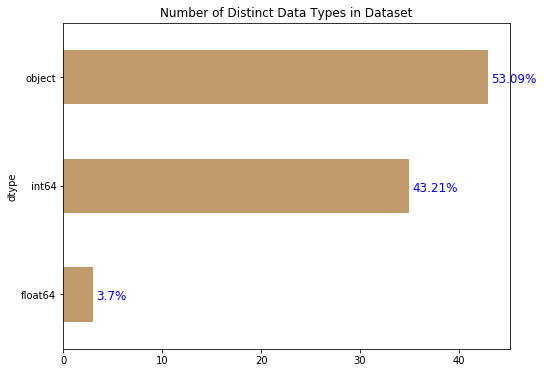

In [7]:
plot_dtypes(train)

#### Plotting features with missing values

The function *plot_missing* identifies the percentage of missing rows for every feature in our dataset.

In [8]:
def plot_missing(df, showplot = True):
    
    # Get dataframe with percentage of missing values
    missing = pd.DataFrame(df.isnull().sum(), columns = ['perc_missing'])
    missing = missing.loc[missing['perc_missing'] > 0]
    missing = (missing/len(df))*100
    
    # Plot resulting dataframe
    missing = missing.sort_values('perc_missing')
    if(showplot):
        ax = missing.plot(
            kind = 'barh',
            figsize=(10,8),
            title = 'Percentage of Missing Values in Dataset by Feature',
            legend = None,
            color = 'coral'
        )

        # Set individual bar lables
        for i in ax.patches:
            # get_width to move left or right; get_y to move up or down
            ax.text(
                i.get_width()+.3, i.get_y(),
                str(round(i.get_width(), 2)), 
                fontsize=12,
                color='blue'
            )

        plt.style.use('ggplot')
        plt.show()
    
    return missing

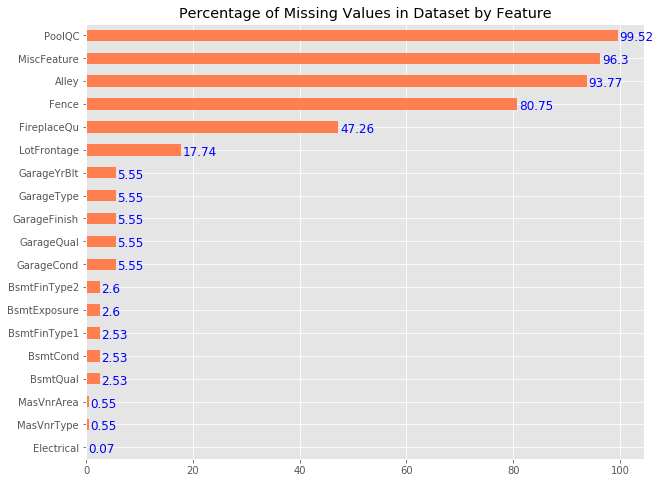

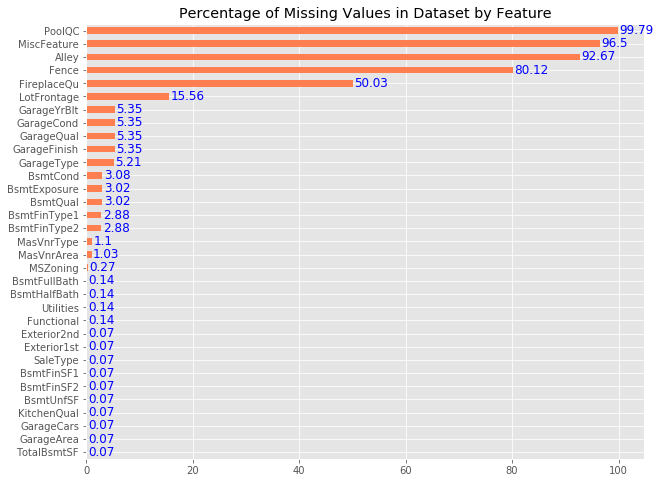

In [9]:
missing_train = plot_missing(train)
missing_test = plot_missing(test)

The distribution of missing values in train set and test set are quite similar. We will deal with these missing values in the data cleaning section.

#### Plotting features and their interactions

The funciton *plot_categorical_column* allows us to observe a distribution for the categorical variable and its interactions with the target variable and other subcolumns.

In [10]:
def plot_categorical_column(df, col, target, size, *subcols):
    num_subcols = len(subcols) 
    # Two charts per subcolumn
    rows_subcols = num_subcols*2
    # Two charts for required categorical feature
    plots_total = 2 + rows_subcols
    
    fig_shape = (plots_total, 1)
    # Height should be a factor of total plots
    fig = plt.figure(figsize=(18, 4*plots_total*size))
    plt.subplots_adjust(hspace=0.5)
    
    # First plot for required categorical feature
    # Plot distribution
    ax1 = plt.subplot2grid(fig_shape, (0,0))
    df[col].value_counts(dropna = False, sort = True).plot(
        kind = 'barh', 
        ax = ax1, 
        title = 'Categorical Count for ' + col
    )
    
    # Second plot for required categorical feature
    # Plot median of target variable for each unique value in main categorical feature
    ax2 = plt.subplot2grid(fig_shape, (1,0))
    df[[col, target]].groupby(col).median().plot(
        kind = 'barh', 
        ax = ax2, 
        title = 'Median of ' + target + ' with respect to ' + col, 
        legend = None
    )
    
    # Generate two plots for subcolumns
    for i, subcol in zip(range(num_subcols), subcols):
        
        # First subcolumn plot
        ax = plt.subplot2grid(fig_shape, (2*i + 2,0))
        # If subcolumn has null values, plot interaction of null values
        if df[subcol].isnull().sum():
            df[[col, subcol]].loc[df[subcol].isnull() == True].groupby(col).size().plot(
                kind = 'barh', 
                ax = ax, 
                title = 'Amount of Nulls in ' + subcol + ' with respect to ' + col
            )
        else:
            if df[subcol].dtype != 'O':
                # If no null values, and a number, plot histogram
                df[subcol].plot(
                    kind = 'hist', 
                    bins = 100,
                    ax = ax, 
                    title = 'Histogram for ' + subcol, 
                    color = 'orange'
                )
            else:
                # If no null values, and an object (categorical feature), plot distribution
                df[subcol].value_counts().plot(
                    kind = 'barh', 
                    ax = ax, 
                    title = 'Categorical counts for ' + subcol
                )
                
        # Second subcolumn plot 
        ax = plt.subplot2grid(fig_shape, (2*i + 3,0))
        # If numeric field, plot median for each unique value in main categorical feature
        if df[subcol].dtype != 'O':
            df[[col, subcol]].groupby(col).median().plot(
                kind = 'barh', 
                ax = ax, 
                title = 'Median Value of ' + subcol + ' with respect to ' + col, 
                legend = None
            )
        else:
            # If categorical field, plot stacked interactions of both categories
            df.groupby([col, subcol]).size().unstack().plot(
                kind = 'barh', 
                ax = ax, 
                title = 'Stacked category interactions for ' + col + ' ' + subcol, 
                cmap = plt.get_cmap('tab20')
            )
        
    plt.style.use('ggplot')
    plt.show()

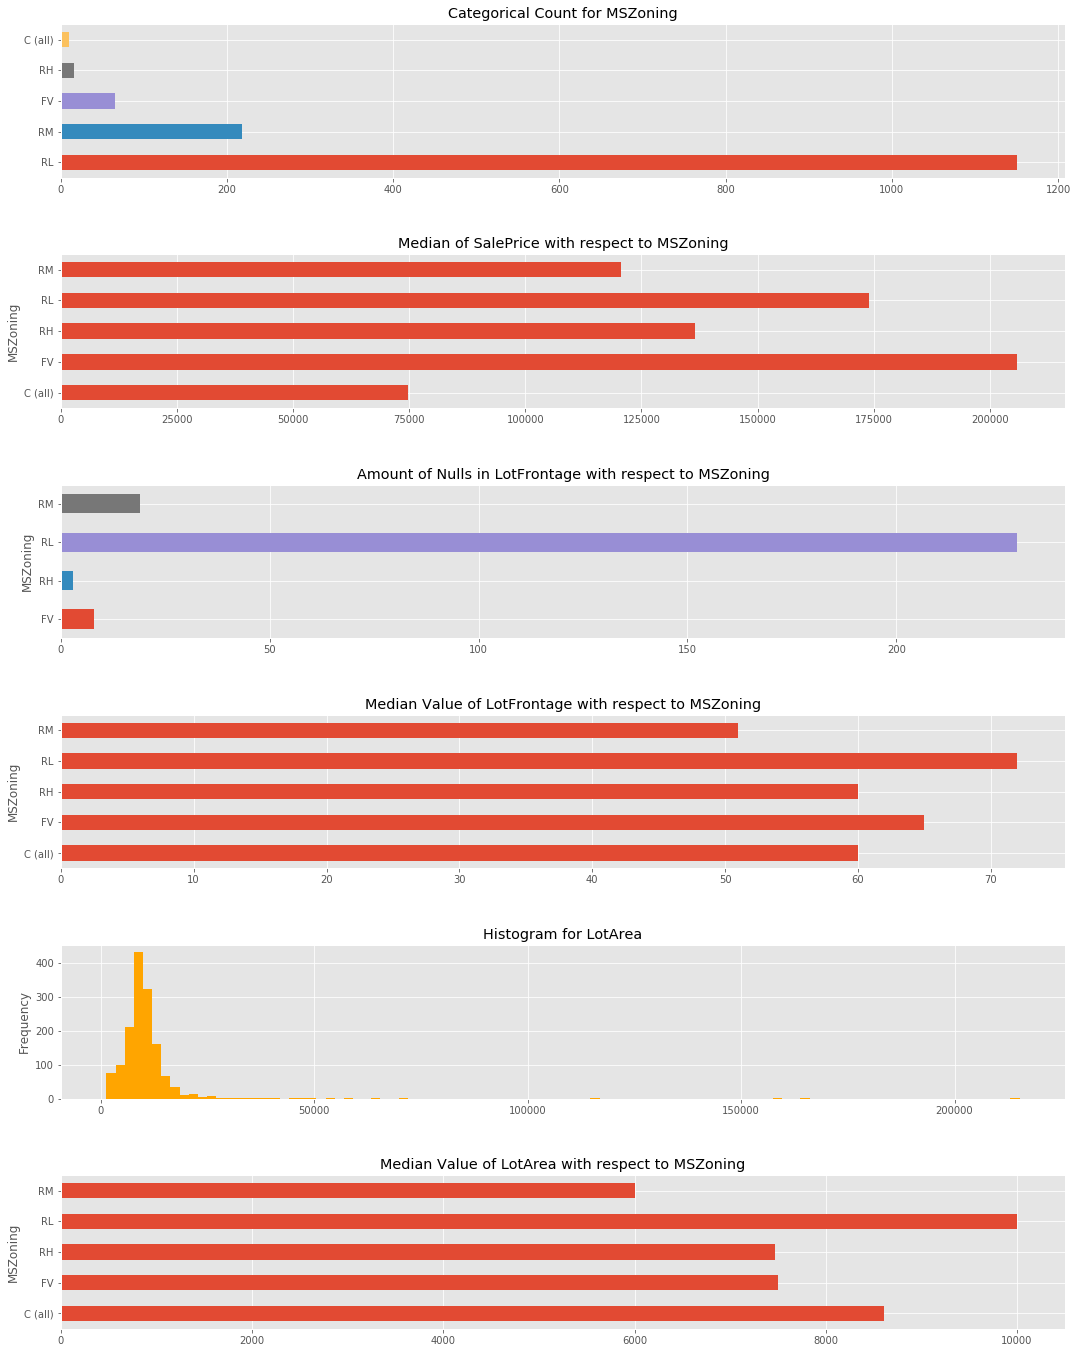

In [11]:
plot_categorical_column(train, 'MSZoning', 'SalePrice', 1, 'LotFrontage', 'LotArea')

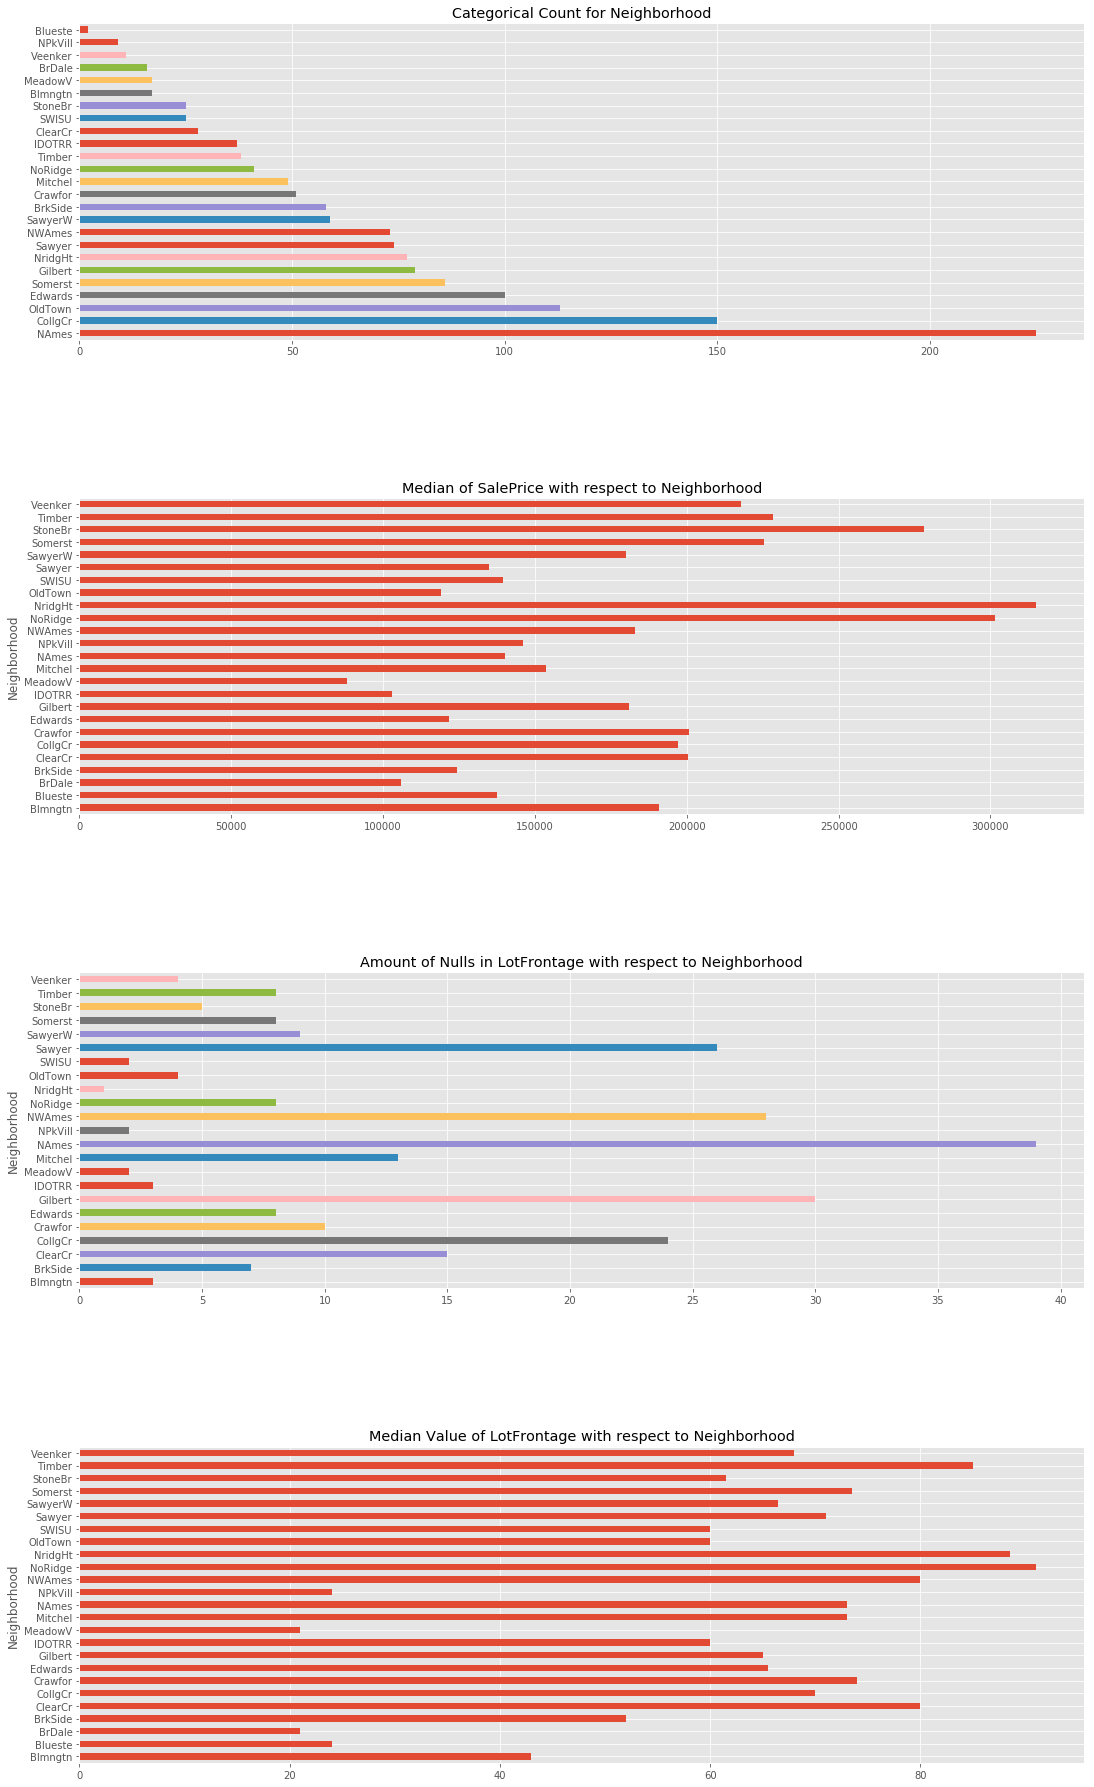

In [12]:
plot_categorical_column(train, 'Neighborhood', 'SalePrice', 2, 'LotFrontage')

#### Correlation Matrix

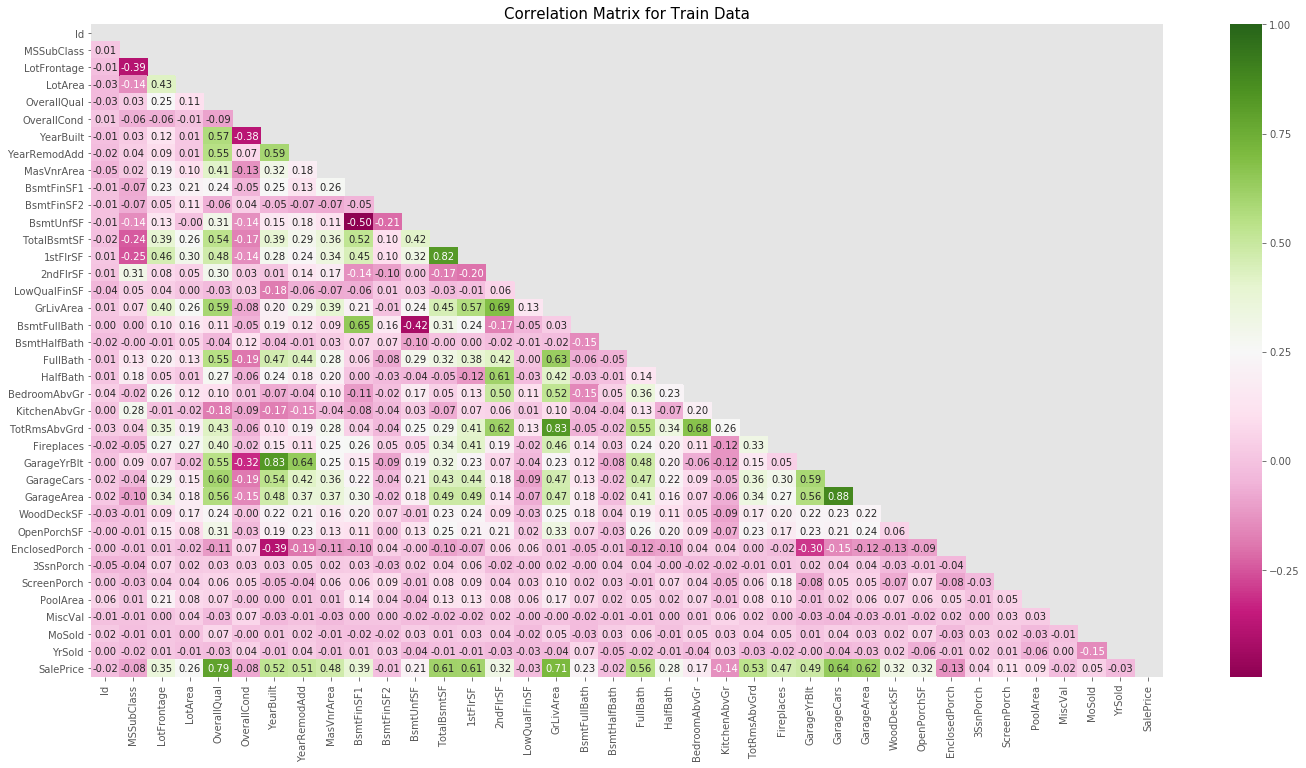

In [13]:
fig = plt.figure(figsize = (24, 12))

corr = train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    corr, 
    mask = mask, 
    cmap = 'PiYG', 
    annot = True, 
    fmt=".2f")

plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.title('Correlation Matrix for Train Data', fontsize = 15)
plt.show()

## Data Cleaning

Preserve original train and test dataframe

In [14]:
new_train = train.copy()
new_test = test.copy()

new_train.drop('Id', axis = 1, inplace = True)
new_test.drop('Id', axis = 1, inplace = True)

### Handle Missing Values

#### Lot Frontage

In our EDA section, we found the relationship between *Neighborhood* and *LotFrontage*. To handle missing values, we can use the median *LotFrontage* for each neighborhood. To dig into this idea a little more, let's draw a boxplot for these two features.

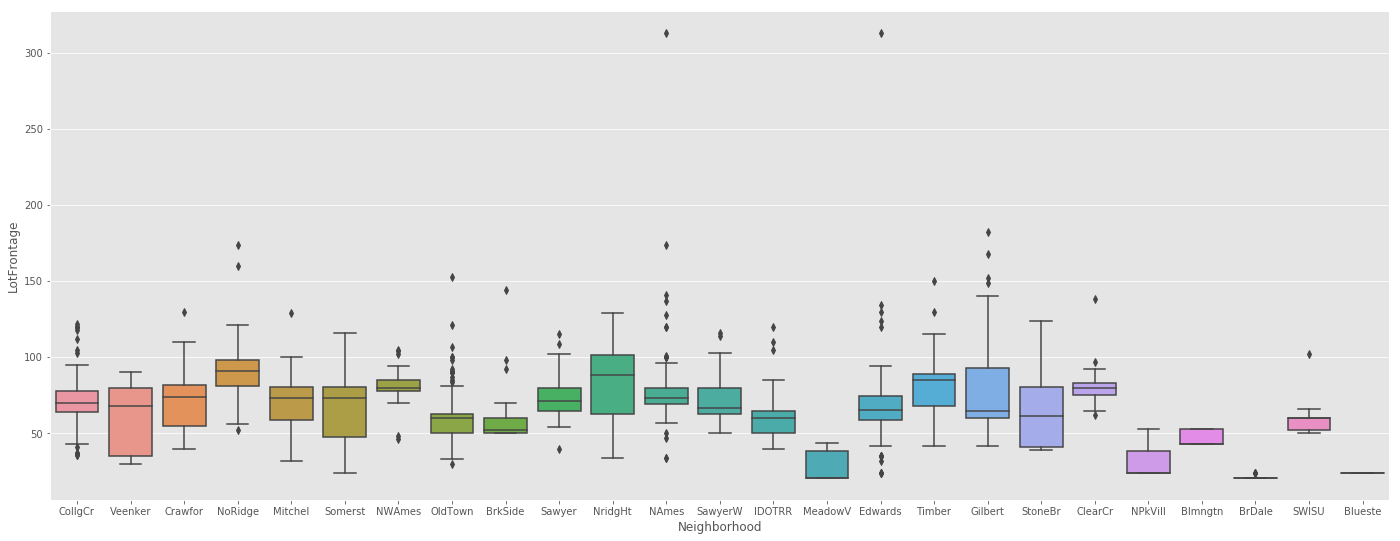

In [15]:
fig = plt.figure(figsize = (24, 9))
sns.boxplot(
    x = new_train['Neighborhood'],
    y = new_train['LotFrontage'],
)
plt.show()

In [16]:
lotfrontage_by_neighborhood = new_train.groupby(['Neighborhood'])['LotFrontage'].agg({
    'median': np.median,
    'count': np.size,
    'std': np.std,
}).reset_index()
lotfrontage_by_neighborhood.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Neighborhood,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
median,43,24,21,52,80,70,74,65.5,65,60,21,73,73,24,80,91,88.5,60,60,71,66.5,73.5,61.5,85,68
count,17,2,16,58,28,150,51,100,79,37,17,49,225,9,73,41,77,113,25,74,59,86,25,38,11
std,4.9901,0,1.20934,15.5285,18.8751,16.3593,19.4361,32.4318,32.7482,18.2827,10.108,22.1003,23.6019,14.1506,10.6144,25.3201,24.9912,18.17,10.5396,14.7286,14.7209,22.5623,23.4456,23.7991,25.5976


In [17]:
def fill_lot_frontage(row):
    return lotfrontage_by_neighborhood[lotfrontage_by_neighborhood['Neighborhood'] == row['Neighborhood']]['median'].values[0]

In [18]:
new_train['LotFrontage'] = new_train.apply(lambda row: fill_lot_frontage(row) if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1)
new_test['LotFrontage'] = new_test.apply(lambda row: fill_lot_frontage(row) if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1)

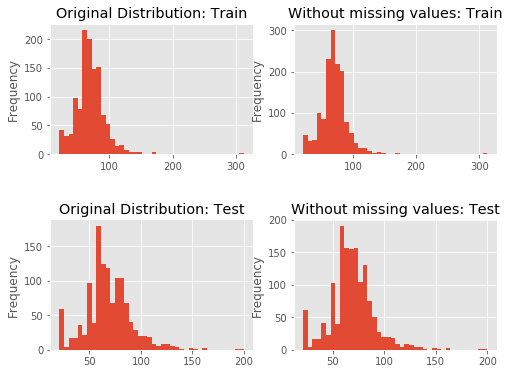

In [19]:
fig = plt.figure(figsize = (8, 6))
plt.subplots_adjust(hspace=0.5)

fig_shape = (2,2)

ax1 = plt.subplot2grid(fig_shape, (0,0))
train.LotFrontage.plot(
    kind = 'hist',
    ax = ax1, 
    bins = 40,
    title = 'Original Distribution: Train'
)


ax1 = plt.subplot2grid(fig_shape, (0,1))
new_train.LotFrontage.plot(
    kind = 'hist', 
    ax = ax1, 
    bins = 40,
    title = 'Without missing values: Train'
)

ax1 = plt.subplot2grid(fig_shape, (1,0))
test.LotFrontage.plot(
    kind = 'hist',
    ax = ax1, 
    bins = 40,
    title = 'Original Distribution: Test'
)


ax1 = plt.subplot2grid(fig_shape, (1,1))
new_test.LotFrontage.plot(
    kind = 'hist', 
    ax = ax1, 
    bins = 40,
    title = 'Without missing values: Test'
)


plt.show()

#### PoolQC

In [20]:
new_train["PoolQC"] = new_train["PoolQC"].fillna("None")
new_test["PoolQC"] = new_test["PoolQC"].fillna("None")

#### MiscFeature

In [21]:
new_train["MiscFeature"] = new_train["MiscFeature"].fillna("None")
new_test["MiscFeature"] = new_test["MiscFeature"].fillna("None")

#### Alley

In [22]:
new_train["Alley"] = new_train["Alley"].fillna("None")
new_test["Alley"] = new_test["Alley"].fillna("None")

#### Fence

In [23]:
new_train["Fence"] = new_train["Fence"].fillna("None")
new_test["Fence"] = new_test["Fence"].fillna("None")

#### FireplaceQu

In [24]:
new_train["FireplaceQu"] = new_train["FireplaceQu"].fillna("None")
new_test["FireplaceQu"] = new_test["FireplaceQu"].fillna("None")

#### Garage Features

In [25]:
# Categorical
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    new_train[col] = new_train[col].fillna('None')
    new_test[col] = new_test[col].fillna('None')
    
# Numeric
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    new_train[col] = new_train[col].fillna(0)
    new_test[col] = new_test[col].fillna(0)

#### Basement Features

In [26]:
# Categorical
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    new_train[col] = new_train[col].fillna('None')
    new_test[col] = new_test[col].fillna('None')
    
# Numeric
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    new_train[col] = new_train[col].fillna(0)
    new_test[col] = new_test[col].fillna(0)

#### Masonry veneer Features

In [27]:
# Categorical
new_train["MasVnrType"] = new_train["MasVnrType"].fillna("None")
new_test["MasVnrType"] = new_test["MasVnrType"].fillna("None")

#Numeric
new_train["MasVnrArea"] = new_train["MasVnrArea"].fillna(0)
new_test["MasVnrArea"] = new_test["MasVnrArea"].fillna(0)

#### MSZoning

In [28]:
new_test['MSZoning'] = new_test['MSZoning'].fillna(train['MSZoning'].mode()[0])

#### Remaining Features

In [29]:
missing_new_train = plot_missing(new_train, showplot = False)
missing_new_train

,perc_missing
Electrical,0.068493


In [30]:
missing_new_test = plot_missing(new_test, showplot = False)
missing_new_test

,perc_missing
Exterior1st,0.06854
Exterior2nd,0.06854
KitchenQual,0.06854
SaleType,0.06854
Utilities,0.13708
Functional,0.13708


In [31]:
cols_to_drop = []
cols_to_clean = []

In [32]:
def handle_na(train, test, cols_to_clean, cols_to_drop):
    if(cols_to_drop):
        train.drop(cols_to_drop, axis = 1, inplace = True)
        test.drop(cols_to_drop, axis = 1, inplace = True)
    
    if(cols_to_clean):
        for col in cols_to_clean:
            train[col+'_is_na'] = train[col].isnull()
            test[col+'_is_na'] = test[col].isnull()
        
    for col in test.columns:
        # If numeric, fill with median
        if np.issubdtype(train[col].dtype, np.number):
            train.loc[train[col].isnull() == True, col] = train[col].median()
            test.loc[test[col].isnull() == True, col] = train[col].median()

        # If object, fill with mode
        if (train[col].dtype == 'O'):
            train.loc[train[col].isnull() == True, col] = train[col].mode().iloc[0]
            test.loc[test[col].isnull() == True, col] = train[col].mode().iloc[0]
            
    print(f'Shape of Train Set: {train.shape}')
    print(f'Shape of Test Set : {test.shape}')

    return train, test

In [33]:
new_train, new_test = handle_na(new_train, new_test, cols_to_clean, cols_to_drop)

Shape of Train Set: (1460, 80)
Shape of Test Set : (1459, 79)


### Label Encoding

In [34]:
def label_encode(train, test):
    combined = train.append(test, sort = False)
    for col in test.columns:
        if (train[col].dtype == 'O'):
            le = LabelEncoder()
            le.fit(combined[col])
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
    return train, test

In [35]:
new_train, new_test = label_encode(new_train, new_test)

## Feature Engineering

#### Total Square Footage

In [36]:
new_train['TotalSF'] = new_train['TotalBsmtSF'] + new_train['1stFlrSF'] + new_train['2ndFlrSF']
new_test['TotalSF'] = new_test['TotalBsmtSF'] + new_test['1stFlrSF'] + new_test['2ndFlrSF']

## Training

### Generating Validation Set

In [37]:
new_train['SalePrice'] = np.log(new_train['SalePrice'])

In [38]:
def split(df, target, test_size = 0.1):
    X_train, X_valid, y_train, y_valid = train_test_split(df.drop(target, axis = 1), df[target], test_size = test_size, random_state = 42)
    print(f'Shape of Train Set: {X_train.shape}')
    print(f'Shape of Valid Set: {X_valid.shape}')
    return X_train, X_valid, y_train, y_valid

In [39]:
X_train, X_valid, y_train, y_valid = split(new_train, 'SalePrice')

Shape of Train Set: (1314, 80)
Shape of Valid Set: (146, 80)


### XGBoost

In [171]:
def xgtrain(X_train, X_valid, y_train, y_valid):
    regressor = XGBRegressor(
        n_estimators = 50000, 
        learning_rate = 0.01,
        max_depth = 3, 
        subsample = 0.5, 
        colsample_bytree = 0.2
        )
    
    regressor_ = regressor.fit(
        X_train.values, y_train.values, 
        eval_metric = 'rmse', 
        eval_set = [
            (X_train.values, y_train.values), 
            (X_valid.values, y_valid.values)
        ],
        verbose = 1000,
        early_stopping_rounds = 500,
        )
    
    return regressor_

In [172]:
%%time
regressor_ = xgtrain(X_train, X_valid, y_train, y_valid)

[0]	validation_0-rmse:11.4169	validation_1-rmse:11.406
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1000]	validation_0-rmse:0.094176	validation_1-rmse:0.111038
[2000]	validation_0-rmse:0.073829	validation_1-rmse:0.105421
[3000]	validation_0-rmse:0.061455	validation_1-rmse:0.103768
Stopping. Best iteration:
[3029]	validation_0-rmse:0.061136	validation_1-rmse:0.103696

CPU times: user 15.6 s, sys: 400 ms, total: 16 s
Wall time: 16 s


### LightGBM

In [205]:
def lgbtrain(X_train, y_train, X_valid, y_valid):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2_root'},
        'max_depth': 3,
        'learning_rate': 0.01,
        'feature_fraction': 0.2,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'num_leaves': 5
    }
    
    gbm = lgb.train(
        params,
        lgb_train,
        valid_sets = lgb_eval,
        num_boost_round=50000,
        early_stopping_rounds=100,
        verbose_eval = 250
    )
    
    return gbm

In [206]:
%%time
gbm = lgbtrain(X_train, y_train, X_valid, y_valid)

Training until validation scores don't improve for 100 rounds.
[250]	valid_0's rmse: 0.175864
[500]	valid_0's rmse: 0.137123
[750]	valid_0's rmse: 0.125606
[1000]	valid_0's rmse: 0.12205
[1250]	valid_0's rmse: 0.120311
[1500]	valid_0's rmse: 0.119156
[1750]	valid_0's rmse: 0.118569
Early stopping, best iteration is:
[1885]	valid_0's rmse: 0.118312
CPU times: user 888 ms, sys: 264 ms, total: 1.15 s
Wall time: 1.14 s


### Feature Importances

In [ ]:
def plot_feature_importance():
    df_fi = pd.DataFrame(columns = ['features', 'importance'])
    df_fi['features'] = new_test.columns 
    df_fi['importance'] = regressor_.feature_importances_
    
    ax = df_fi.sort_values('importance').plot(
        'features',
        kind = 'barh',
        legend = None,
        title = 'Feature Importances',
        figsize = (18, 25),
        color = 'crimson'
       )
    
    
    # List that will hold plt.patches data
    totals = []

    # Append patch values to list
    for i in ax.patches:
        totals.append(i.get_width())
    
    # Set individual bar lables
    for i in ax.patches:
        # get_width to move left or right; get_y to move up or down
        ax.text(
            i.get_width() + 0.001, i.get_y(),
            str(round(i.get_width(), 3)), 
            fontsize=14,
            color='blue'
        )
    
    plt.style.use('ggplot')
    plt.yticks(fontsize=14)
    plt.show()

In [ ]:
plot_feature_importance()

## Prepare Submission

In [209]:
def prepare_submission(comment = 'latest'):
    xgb_preds = np.exp(regressor_.predict(new_test.values))
    lgb_preds = np.expm1(gbm.predict(new_test.values))
    submission['SalePrice'] = 0.75*xgb_preds + 0.25*lgb_preds
    submission.to_csv('submission' + comment + '.csv', index=False)
    print(submission.head())

In [210]:
prepare_submission('_ensemble')

     Id      SalePrice
0  1461  127128.072116
1  1462  159741.985409
2  1463  183486.381865
3  1464  192468.972276
4  1465  190218.475784


In [164]:
from IPython.display import FileLinks
FileLinks('.')

./
  submission_ensemble.csv
  submission_full_clean.csv
  __notebook_source__.ipynb

In [ ]:
new_train.to_feather('new_train')
new_test.to_feather('new_test')

In [ ]:
# train[['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'YearBuilt']]

In [ ]:
train['GarageYrBlt'].plot(kind = 'hist')
plt.show()

In [ ]:
train['YearBuilt'].plot(kind = 'hist')
plt.show()

In [ ]:
(train['GarageYrBlt'] - train['YearBuilt']).plot(kind = 'hist')
plt.show()